# Appendix Cancer Prediction Dataset

# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [5]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", RobustScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,15))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA

In [6]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv", nrows=50000)
df

,Patient_ID,Country,Age,Gender,BMI,Smoking_Status,Alcohol_Consumption,Family_History_Cancer,Genetic_Mutations,Chronic_Diseases,...,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Tumor_Markers,Symptom_Severity,Diagnosis_Delay_Days,Treatment_Type,Survival_Years_After_Diagnosis,Appendix_Cancer_Prediction
0,PID_000001,China,67,Female,28.6,No,Low,Yes,No,Diabetes,...,228,8.1,4.4,361,Negative,Mild,691,Surgery,6.5,Yes
1,PID_000002,Saudi Arabia,83,Female,19.4,No,Low,No,No,Diabetes,...,186,9.7,6.2,235,Negative,Moderate,275,Chemotherapy,1.6,No
2,PID_000003,France,52,Female,17.2,No,Low,Yes,No,Diabetes,...,231,8.2,4.6,269,Negative,Moderate,668,Chemotherapy,0.7,No
3,PID_000004,Russia,71,Male,31.8,Yes,Low,No,No,None,...,151,6.8,6.0,193,Negative,Moderate,256,Radiation,2.1,No
4,PID_000005,USA,19,Female,17.7,No,Low,No,No,Hypertension,...,236,6.7,4.9,396,Negative,Mild,370,Radiation,0.5,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,PID_049996,Germany,78,Female,31.7,Yes,Moderate,No,No,Diabetes,...,220,5.4,5.8,201,Negative,Mild,214,Chemotherapy,7.2,No
49996,PID_049997,India,79,Female,30.5,No,High,Yes,No,Diabetes,...,280,7.3,4.8,391,Positive,Mild,416,Chemotherapy,6.3,Yes
49997,PID_049998,France,35,Male,14.2,No,Low,No,No,Diabetes,...,240,9.5,5.2,225,Negative,Mild,492,Radiation,1.9,No
49998,PID_049999,Brazil,84,Other,25.4,Yes,Moderate,No,Yes,Hypertension,...,188,3.9,4.8,169,Negative,Moderate,67,Surgery,6.4,No


# Check For Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: Patient_ID                        0
Country                           0
Age                               0
Gender                            0
BMI                               0
Smoking_Status                    0
Alcohol_Consumption               0
Family_History_Cancer             0
Genetic_Mutations                 0
Chronic_Diseases                  0
Physical_Activity_Level           0
Diet_Type                         0
Radiation_Exposure                0
Previous_Cancers                  0
Blood_Pressure                    0
Cholesterol_Level                 0
White_Blood_Cell_Count            0
Red_Blood_Cell_Count              0
Platelet_Count                    0
Tumor_Markers                     0
Symptom_Severity                  0
Diagnosis_Delay_Days              0
Treatment_Type                    0
Survival_Years_After_Diagnosis    0
Appendix_Cancer_Prediction        0
dtype: int64
The amount of Duplicated Values 0


# Check For Class Imbalance

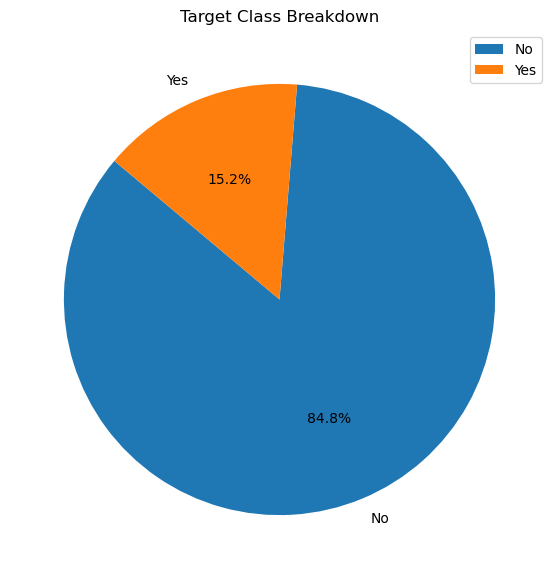

In [6]:
check_class_imbalance(df["Appendix_Cancer_Prediction"])

In [8]:
df.dtypes

Patient_ID                         object
Country                            object
Age                                 int64
Gender                             object
BMI                               float64
Smoking_Status                     object
Alcohol_Consumption                object
Family_History_Cancer              object
Genetic_Mutations                  object
Chronic_Diseases                   object
Physical_Activity_Level            object
Diet_Type                          object
Radiation_Exposure                 object
Previous_Cancers                   object
Blood_Pressure                      int64
Cholesterol_Level                   int64
White_Blood_Cell_Count            float64
Red_Blood_Cell_Count              float64
Platelet_Count                      int64
Tumor_Markers                      object
Symptom_Severity                   object
Diagnosis_Delay_Days                int64
Treatment_Type                     object
Survival_Years_After_Diagnosis    

In [9]:
df.describe()

,Age,BMI,Blood_Pressure,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Diagnosis_Delay_Days,Survival_Years_After_Diagnosis
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,53.455680,25.014378,134.664520,224.284260,7.004210,4.998114,273.483780,363.718700,4.991960
std,20.785097,4.969019,26.032372,43.380919,1.490884,0.501206,72.229589,211.202719,4.970217
min,18.000000,4.800000,90.000000,150.000000,1.100000,2.900000,150.000000,0.000000,0.000000
25%,36.000000,21.600000,112.000000,187.000000,6.000000,4.700000,211.000000,180.000000,1.400000
50%,53.000000,25.000000,135.000000,224.000000,7.000000,5.000000,273.000000,365.000000,3.500000
75%,71.000000,28.300000,157.000000,262.000000,8.000000,5.300000,336.000000,547.000000,6.900000
max,89.000000,48.100000,179.000000,299.000000,13.000000,7.100000,399.000000,729.000000,53.800000


In [8]:
df.drop(columns=["Patient_ID"], inplace=True)

In [9]:
numeric_cols = df.select_dtypes(exclude="object")
cat_cols = df.select_dtypes(include="object")

In [10]:
for col in cat_cols:
  print(f"Unique Values for {col}: {df[col].unique()}")

Unique Values for Country: ['China' 'Saudi Arabia' 'France' 'Russia' 'USA' 'Japan' 'UK' 'Spain'
 'Australia' 'India' 'Brazil' 'Germany' 'Italy' 'Argentina' 'Canada'
 'Mexico' 'Indonesia' 'South Korea' 'Turkey' 'Norway' 'South Africa'
 'Poland' 'Netherlands' 'Egypt' 'Sweden']
Unique Values for Gender: ['Female' 'Male' 'Other']
Unique Values for Smoking_Status: ['No' 'Yes']
Unique Values for Alcohol_Consumption: ['Low' 'Moderate' 'High']
Unique Values for Family_History_Cancer: ['Yes' 'No']
Unique Values for Genetic_Mutations: ['No' 'Yes']
Unique Values for Chronic_Diseases: ['Diabetes' 'None' 'Hypertension']
Unique Values for Physical_Activity_Level: ['High' 'Low' 'Moderate']
Unique Values for Diet_Type: ['Non-Vegetarian' 'Vegetarian' 'Vegan']
Unique Values for Radiation_Exposure: ['No' 'Yes']
Unique Values for Previous_Cancers: ['No' 'Yes']
Unique Values for Tumor_Markers: ['Negative' 'Positive']
Unique Values for Symptom_Severity: ['Mild' 'Moderate' 'Severe']
Unique Values for Treatme

Column: Country


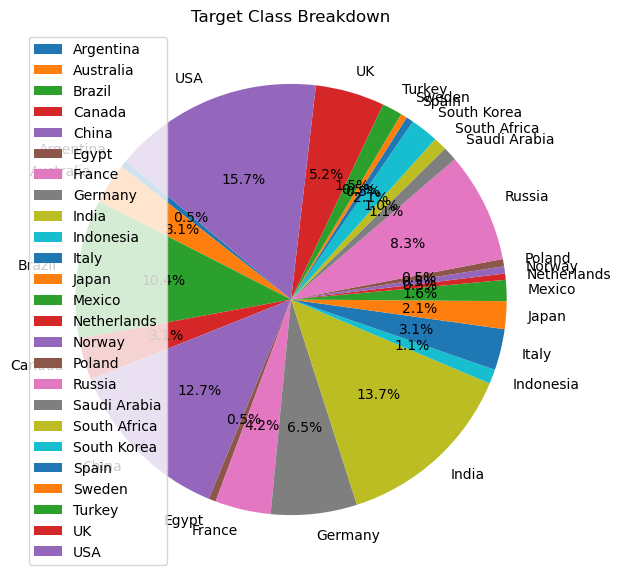

Column: Gender


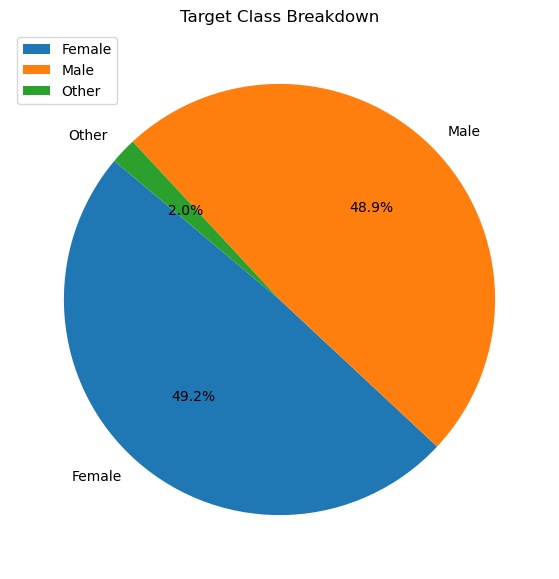

Column: Smoking_Status


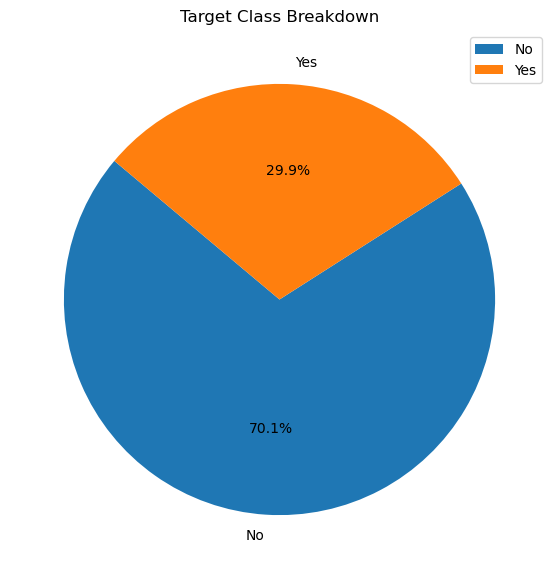

Column: Alcohol_Consumption


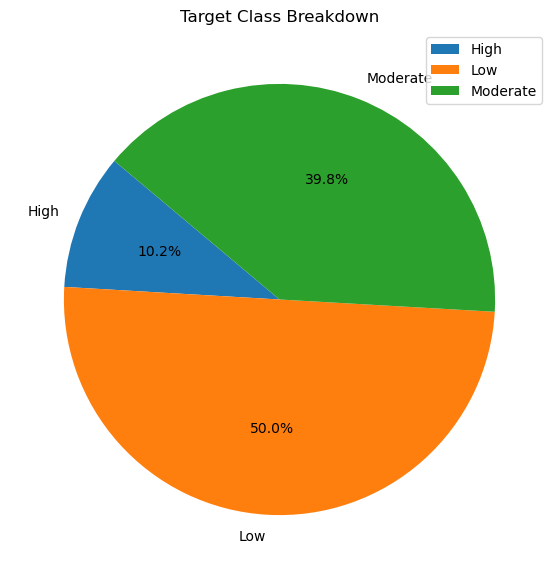

Column: Family_History_Cancer


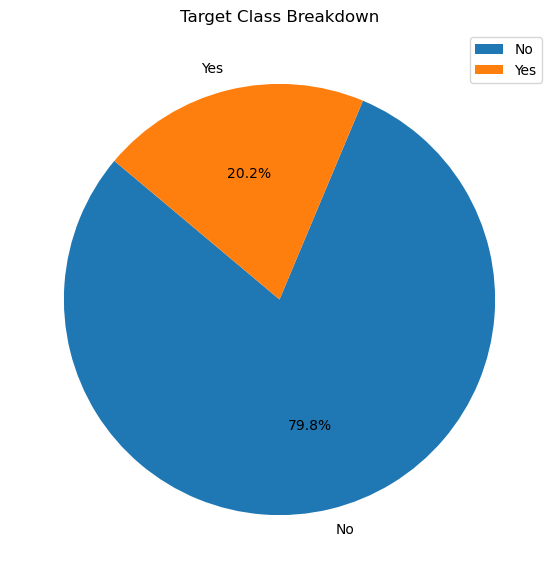

Column: Genetic_Mutations


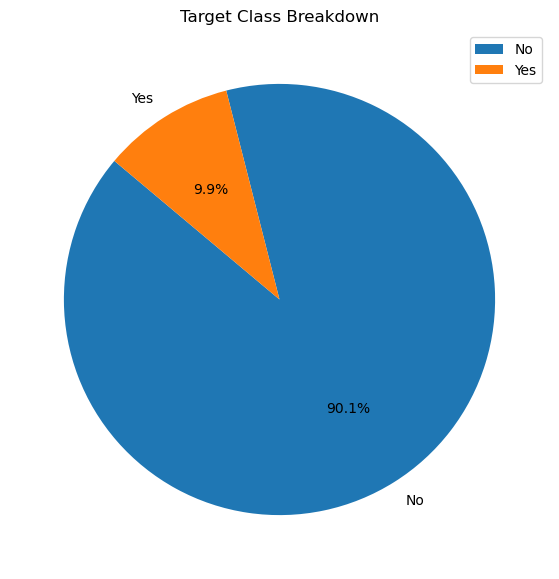

Column: Chronic_Diseases


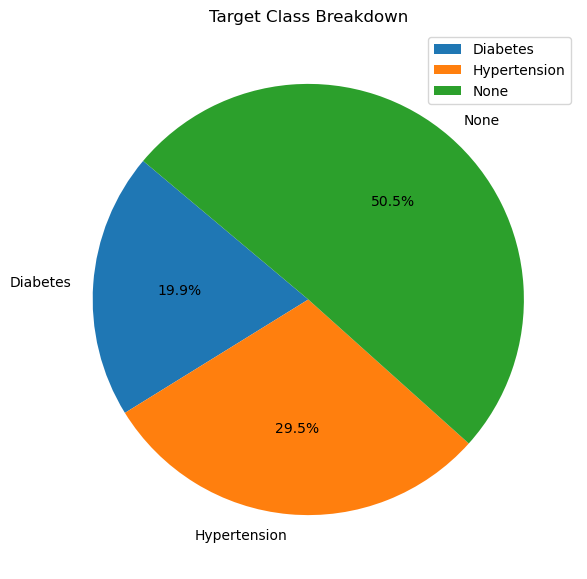

Column: Physical_Activity_Level


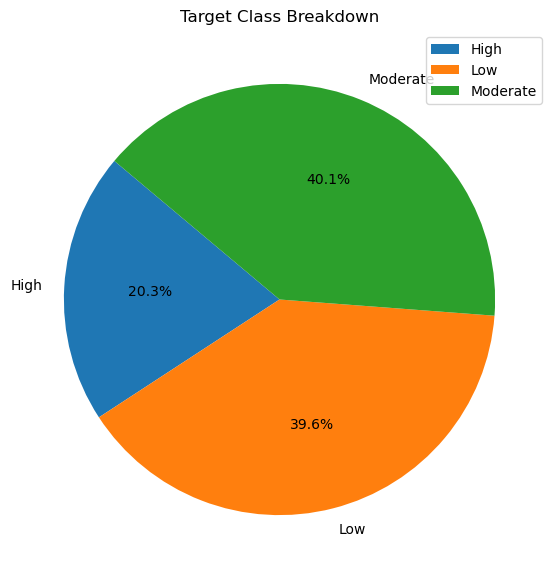

Column: Diet_Type


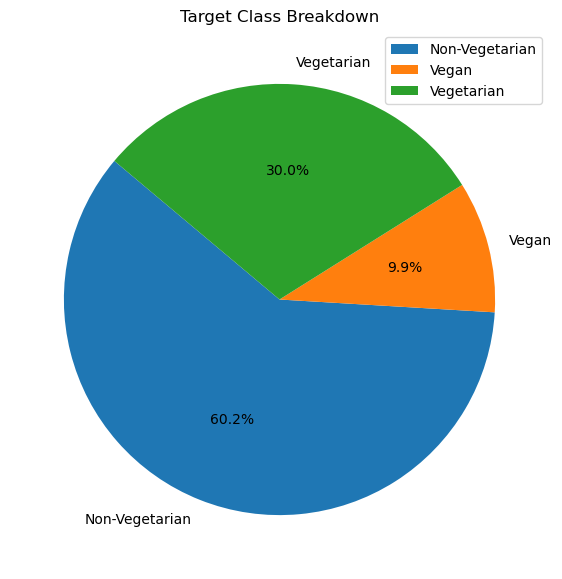

Column: Radiation_Exposure


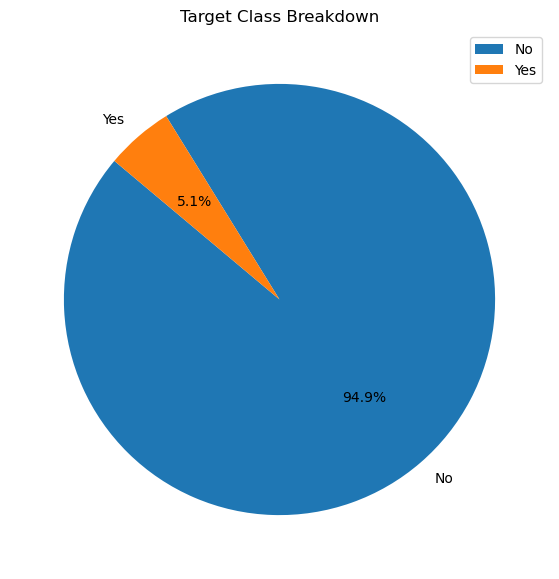

Column: Previous_Cancers


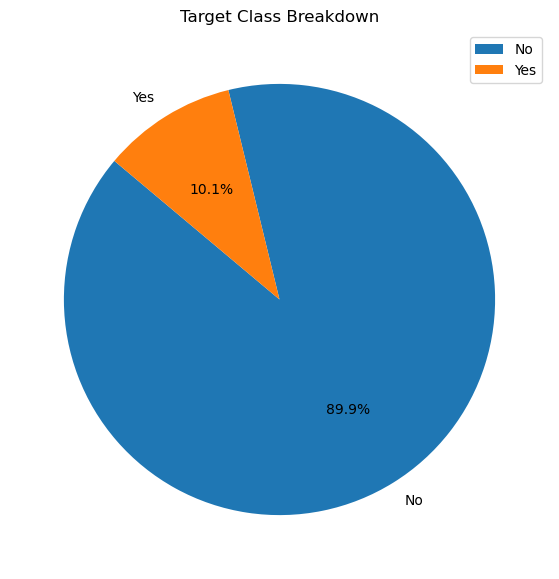

Column: Tumor_Markers


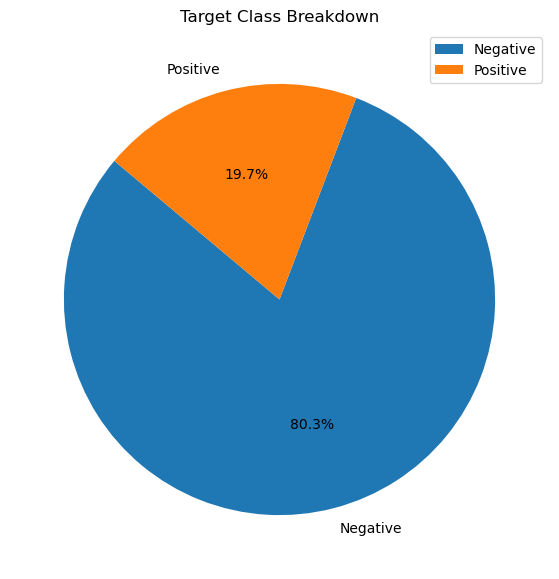

Column: Symptom_Severity


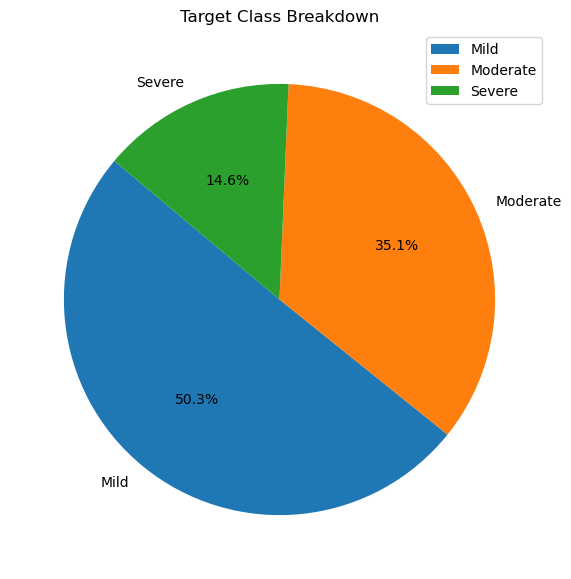

Column: Treatment_Type


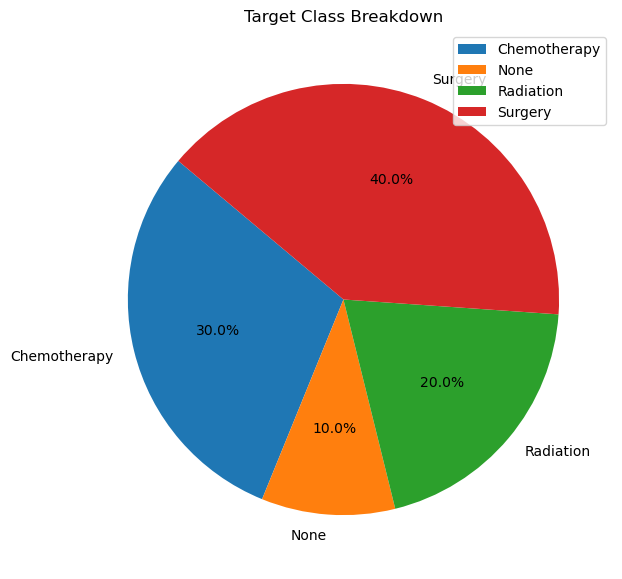

Column: Appendix_Cancer_Prediction


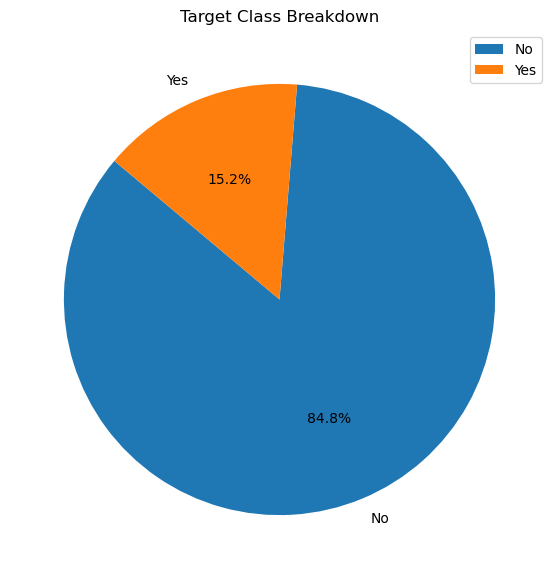

In [12]:
for col in cat_cols:
  print(f"Column: {col}")
  check_class_imbalance(df[col])